# Implementing the Ahnert and Payne scheme for a general 1-qubit  POVM on qiskit.



In [1]:
from numpy import pi
import numpy as np

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit.tools.visualization import circuit_drawer
from qiskit import Aer
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram


/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


ModuleNotFoundError: No module named 'qiskit.backends'

## Testing 

/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)


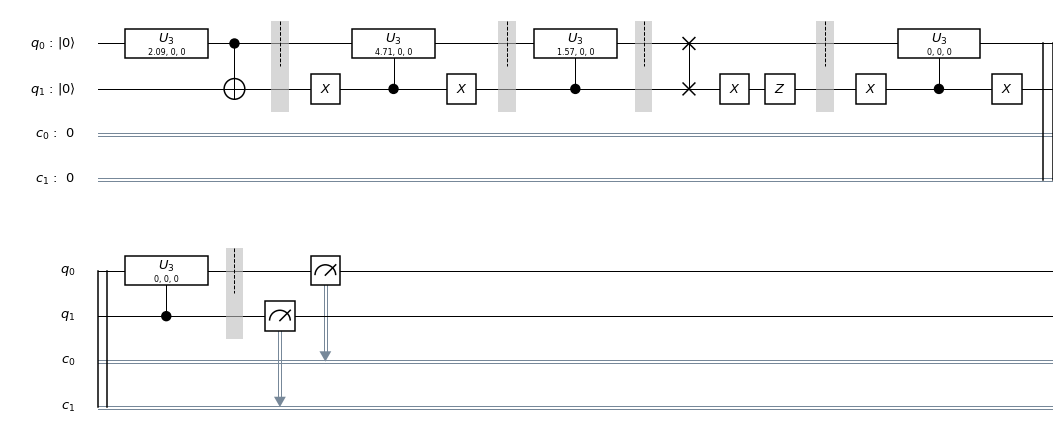

In [4]:
# Create a Quantum Register with 3 qubits.
q = QuantumRegister(2, 'q')

# Create a Quantum Circuit acting on the q register
qc = QuantumCircuit(q)

# prepare the input state (the input state will be represented by qubit 0)
qc.u3(pi*2/3, 0 ,0, q[0])
# qc.barrier(q)

# Apply the POVM
first_AP_module_new(qc,q,pi/4,pi/4, 0, 0)

# Add Measurements

# Create a Classical Register with 3 bits.
c = ClassicalRegister(2, 'c')
# Create a Quantum Circuit
meas = QuantumCircuit(q, c)
meas.barrier(q)
# map the quantum measurement to the classical bits
meas.measure(q,c)

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc+meas

circuit_drawer(qc)


### Run the simulator

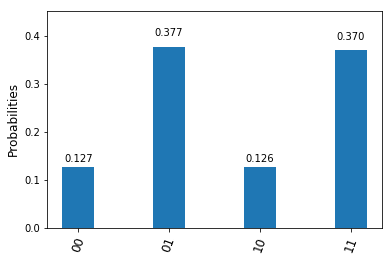

In [5]:
# Run the quantum circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')
shots = 8096

# Create a Quantum Program for execution 
job = execute(qc, backend, shots = shots)

# execute
result = job.result()

counts = result.get_counts(qc)
plot_histogram(counts)

### REAL DEVICE EXPERIMENT


In [17]:
# IBMQ.save_account(token)
IBMQ.load_accounts()


shots = 8192           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 10       # Maximum number of credits to spend on executions. 
n_qubits = 3


large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration()['n_qubits'] == 5 and
                                                       not x.configuration()['simulator'])
backend = least_busy(large_enough_devices)
# backend = IBMQ.backends(filters=lambda x: x.name == 'ibmqx5')
print("The best backend is " + backend.name())

The best backend is ibmqx4


In [18]:
# <<<<<<<<<<< EXECUTING real experiment >>>>>>>>>>>>>>
run = 1  # keep 0 untill you want to run the experiment, to avoid running by mistake. It is slow and cost credits!
if run:
    job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    result = job_exp.result()

Got a 502 code response to https://quantumexperience.ng.bluemix.net/api/Jobs/5c45f9b0631919005a45b27b/status?access_token=LfH9MSetMTFzTOVRpzmYtWL2GabfhwmPFxMsNFc5o62Xb5cSB5wvSnM7Djv0x6c9: 502 Bad Gateway: Registered endpoint failed to handle the request.

Got a 502 code response to https://quantumexperience.ng.bluemix.net/api/Jobs/5c45f9b0631919005a45b27b/status?access_token=LfH9MSetMTFzTOVRpzmYtWL2GabfhwmPFxMsNFc5o62Xb5cSB5wvSnM7Djv0x6c9: 502 Bad Gateway: Registered endpoint failed to handle the request.

Got a 502 code response to https://quantumexperience.ng.bluemix.net/api/Jobs/5c45f9b0631919005a45b27b/status?access_token=LfH9MSetMTFzTOVRpzmYtWL2GabfhwmPFxMsNFc5o62Xb5cSB5wvSnM7Djv0x6c9: 502 Bad Gateway: Registered endpoint failed to handle the request.



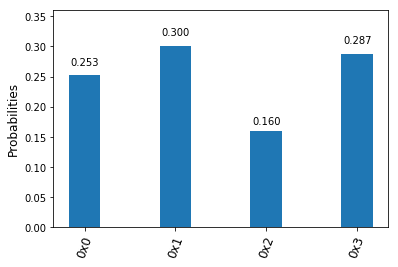

In [9]:
counts = result.get_counts(qc)
plot_histogram(counts)